# Survival Prediction of Lung Cancer Patients Based on Different Feature Selection Methods Using CNN-Cox Models

## Import the Libraries

In [431]:
pip install lifelines

In [432]:
pip install bioservices

In [433]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import requests
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold,train_test_split
from lifelines.utils import concordance_index
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, concatenate, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from bioservices import KEGG

## Prepare the dataset

### Clinical data

#### Load the dataset

In [434]:
clinical_data = pd.read_csv('/content/luad_clinical_patient.txt', sep='\t')

#### Select the relevant columns for analysis

In [435]:
clinical_data = clinical_data[['Patient Identifier', 'Overall Survival Status', 'Overall Survival (Months)']].loc[4:]
clinical_data = clinical_data.rename(columns = {'Overall Survival Status' : 'OS_STATUS', 'Overall Survival (Months)' : 'OS_MONTHS'})

print(clinical_data.head(10))

   Patient Identifier   OS_STATUS OS_MONTHS
4        TCGA-05-4244    0:LIVING         0
5        TCGA-05-4245    0:LIVING     23.98
6        TCGA-05-4249    0:LIVING     50.03
7        TCGA-05-4250  1:DECEASED      3.98
8        TCGA-05-4382    0:LIVING     19.94
9        TCGA-05-4384    0:LIVING     13.99
10       TCGA-05-4389    0:LIVING     44.97
11       TCGA-05-4390    0:LIVING     36.99
12       TCGA-05-4395  1:DECEASED         0
13       TCGA-05-4396  1:DECEASED      9.95


#### Convert OS_MONTHS values into binary format (1 for deceased, 0 for living)

In [436]:
clinical_data["OS_STATUS"] = clinical_data["OS_STATUS"].apply(lambda x : 1 if x.find('1:') != -1 else 0)

print(clinical_data.head(10))

   Patient Identifier  OS_STATUS OS_MONTHS
4        TCGA-05-4244          0         0
5        TCGA-05-4245          0     23.98
6        TCGA-05-4249          0     50.03
7        TCGA-05-4250          1      3.98
8        TCGA-05-4382          0     19.94
9        TCGA-05-4384          0     13.99
10       TCGA-05-4389          0     44.97
11       TCGA-05-4390          0     36.99
12       TCGA-05-4395          1         0
13       TCGA-05-4396          1      9.95


#### Check for unnecessary data

In [437]:
print(clinical_data['OS_STATUS'].value_counts())
print(clinical_data['OS_MONTHS'].value_counts().head(10))

OS_STATUS
0    334
1    188
Name: count, dtype: int64
OS_MONTHS
[Not Available]    9
25.99              4
0                  4
15.64              3
14.29              3
12.65              3
18.66              3
20.04              3
29.43              3
18.99              3
Name: count, dtype: int64


#### Drop rows where OS_MONTHS is 0 or '[Not Available]'

In [438]:
clinical_data = clinical_data[
    (clinical_data['OS_MONTHS'] != '0') &
    (clinical_data['OS_MONTHS'] != '[Not Available]')
]

print(clinical_data.head(10))

   Patient Identifier  OS_STATUS OS_MONTHS
5        TCGA-05-4245          0     23.98
6        TCGA-05-4249          0     50.03
7        TCGA-05-4250          1      3.98
8        TCGA-05-4382          0     19.94
9        TCGA-05-4384          0     13.99
10       TCGA-05-4389          0     44.97
11       TCGA-05-4390          0     36.99
13       TCGA-05-4396          1      9.95
14       TCGA-05-4397          1     24.01
15       TCGA-05-4398          0     47.01


#### Reset the index to start from 0

In [439]:
clinical_data = clinical_data.reset_index(drop=True)

print(clinical_data.head(10))

  Patient Identifier  OS_STATUS OS_MONTHS
0       TCGA-05-4245          0     23.98
1       TCGA-05-4249          0     50.03
2       TCGA-05-4250          1      3.98
3       TCGA-05-4382          0     19.94
4       TCGA-05-4384          0     13.99
5       TCGA-05-4389          0     44.97
6       TCGA-05-4390          0     36.99
7       TCGA-05-4396          1      9.95
8       TCGA-05-4397          1     24.01
9       TCGA-05-4398          0     47.01


### Gene data

#### Load the dataset

In [440]:
gene_data = pd.read_csv('/content/luad_gene_data.txt', sep='\t').T

print(gene_data)

                        0          1          2        3       4       5      \
Hugo_Symbol      LOC100130426   UBE2Q2P3   UBE2Q2P3  HMGB1P1  TIMM23   MOXD2   
Entrez_Gene_Id      100130426  100133144  100134869    10357   10431  136542   
TCGA-05-4244-01       -2.2883      0.038     0.0691  -1.9057 -0.0395     NaN   
TCGA-05-4249-01       -2.2883    -0.3514     0.1971   -0.295  0.1945     NaN   
TCGA-05-4250-01       -2.2883    -0.3435    -0.7239  -1.9091  0.7761     NaN   
...                       ...        ...        ...      ...     ...     ...   
TCGA-NJ-A55O-01       -2.2883     0.5729     1.0176  -0.0218  0.0408     NaN   
TCGA-NJ-A55R-01       -2.2883    -0.1679    -0.0462  -0.8099 -0.3206     NaN   
TCGA-NJ-A7XG-01       -2.2883     1.8645     2.7613  -0.4522 -0.6611     NaN   
TCGA-O1-A52J-01       -2.2883     0.4532      1.087  -1.3473  0.7679     NaN   
TCGA-S2-AA1A-01       -2.2883     0.9225    -0.2293  -0.7319  -1.161     NaN   

                     6         7       

#### Change the column name as gene symbol

In [441]:
gene_data.columns = gene_data.iloc[0]
gene_data = gene_data.drop(['Hugo_Symbol', 'Entrez_Gene_Id'])
gene_data = gene_data.astype(float)

print(gene_data)

Hugo_Symbol      LOC100130426  UBE2Q2P3  UBE2Q2P3  HMGB1P1  TIMM23  MOXD2  \
TCGA-05-4244-01       -2.2883    0.0380    0.0691  -1.9057 -0.0395    NaN   
TCGA-05-4249-01       -2.2883   -0.3514    0.1971  -0.2950  0.1945    NaN   
TCGA-05-4250-01       -2.2883   -0.3435   -0.7239  -1.9091  0.7761    NaN   
TCGA-05-4382-01       -2.2883    0.1873   -0.4402  -0.5333 -0.1787    NaN   
TCGA-05-4384-01       -2.2883   -1.2251   -1.3555  -0.8895 -1.1778    NaN   
...                       ...       ...       ...      ...     ...    ...   
TCGA-NJ-A55O-01       -2.2883    0.5729    1.0176  -0.0218  0.0408    NaN   
TCGA-NJ-A55R-01       -2.2883   -0.1679   -0.0462  -0.8099 -0.3206    NaN   
TCGA-NJ-A7XG-01       -2.2883    1.8645    2.7613  -0.4522 -0.6611    NaN   
TCGA-O1-A52J-01       -2.2883    0.4532    1.0870  -1.3473  0.7679    NaN   
TCGA-S2-AA1A-01       -2.2883    0.9225   -0.2293  -0.7319 -1.1610    NaN   

Hugo_Symbol      LOC155060  RNU12-2P    SSX9  LOC317712  ...    ZXDA    ZXD

#### Drop columns with any NaN values

In [442]:
gene_data = gene_data.dropna(axis=1)

print(gene_data)

Hugo_Symbol      LOC100130426  UBE2Q2P3  UBE2Q2P3  HMGB1P1  TIMM23  LOC155060  \
TCGA-05-4244-01       -2.2883    0.0380    0.0691  -1.9057 -0.0395     1.0624   
TCGA-05-4249-01       -2.2883   -0.3514    0.1971  -0.2950  0.1945    -0.0690   
TCGA-05-4250-01       -2.2883   -0.3435   -0.7239  -1.9091  0.7761    -1.4074   
TCGA-05-4382-01       -2.2883    0.1873   -0.4402  -0.5333 -0.1787     0.5870   
TCGA-05-4384-01       -2.2883   -1.2251   -1.3555  -0.8895 -1.1778     0.7614   
...                       ...       ...       ...      ...     ...        ...   
TCGA-NJ-A55O-01       -2.2883    0.5729    1.0176  -0.0218  0.0408     0.6719   
TCGA-NJ-A55R-01       -2.2883   -0.1679   -0.0462  -0.8099 -0.3206     1.1540   
TCGA-NJ-A7XG-01       -2.2883    1.8645    2.7613  -0.4522 -0.6611     1.0220   
TCGA-O1-A52J-01       -2.2883    0.4532    1.0870  -1.3473  0.7679     0.1428   
TCGA-S2-AA1A-01       -2.2883    0.9225   -0.2293  -0.7319 -1.1610     1.1789   

Hugo_Symbol      RNU12-2P  

#### Remove the last '-01' part in index

In [443]:
gene_data.index = gene_data.index.astype(str)
gene_data.index = gene_data.index.str.replace(r'-\d+$', '', regex=True)

print(gene_data)

Hugo_Symbol   LOC100130426  UBE2Q2P3  UBE2Q2P3  HMGB1P1  TIMM23  LOC155060  \
TCGA-05-4244       -2.2883    0.0380    0.0691  -1.9057 -0.0395     1.0624   
TCGA-05-4249       -2.2883   -0.3514    0.1971  -0.2950  0.1945    -0.0690   
TCGA-05-4250       -2.2883   -0.3435   -0.7239  -1.9091  0.7761    -1.4074   
TCGA-05-4382       -2.2883    0.1873   -0.4402  -0.5333 -0.1787     0.5870   
TCGA-05-4384       -2.2883   -1.2251   -1.3555  -0.8895 -1.1778     0.7614   
...                    ...       ...       ...      ...     ...        ...   
TCGA-NJ-A55O       -2.2883    0.5729    1.0176  -0.0218  0.0408     0.6719   
TCGA-NJ-A55R       -2.2883   -0.1679   -0.0462  -0.8099 -0.3206     1.1540   
TCGA-NJ-A7XG       -2.2883    1.8645    2.7613  -0.4522 -0.6611     1.0220   
TCGA-O1-A52J       -2.2883    0.4532    1.0870  -1.3473  0.7679     0.1428   
TCGA-S2-AA1A       -2.2883    0.9225   -0.2293  -0.7319 -1.1610     1.1789   

Hugo_Symbol   RNU12-2P    SSX9   EZHIP  EFCAB8  ...    ZXDA    

#### Check and control the duplicated genes

In [444]:
duplicated_genes = gene_data.columns[gene_data.columns.duplicated()]

print(duplicated_genes)
print(len(duplicated_genes))

Index(['UBE2Q2P3', 'CC2D2B', 'CCDC7', 'CYorf15B', 'C1orf84', 'LINC00875',
       'ELMOD1', 'NBPF16', 'NEBL', 'NKAIN3', 'C5orf23', 'PALM2AKAP2',
       'PLEKHG7', 'QSOX1', 'SH3D20', 'SNAP47', 'NCRNA00185'],
      dtype='object', name='Hugo_Symbol')
17


In [445]:
for gene in duplicated_genes:
  var_gene = np.var(gene_data[gene])

  if var_gene.values[0] < var_gene.values[1]:
    gene_data[gene] = gene_data[gene].iloc[:, 1]
  else:
    gene_data[gene] = gene_data[gene].iloc[:, 0]

gene_data = gene_data.iloc[:, ~gene_data.columns.duplicated()]
print(gene_data)

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Hugo_Symbol   LOC100130426  UBE2Q2P3  HMGB1P1  TIMM23  LOC155060  RNU12-2P  \
TCGA-05-4244       -2.2883    0.0380  -1.9057 -0.0395     1.0624    0.5387   
TCGA-05-4249       -2.2883   -0.3514  -0.2950  0.1945    -0.0690    1.4599   
TCGA-05-4250       -2.2883   -0.3435  -1.9091  0.7761    -1.4074   -2.1796   
TCGA-05-4382       -2.2883    0.1873  -0.5333 -0.1787     0.5870   -0.6958   
TCGA-05-4384       -2.2883   -1.2251  -0.8895 -1.1778     0.7614   -0.3706   
...                    ...       ...      ...     ...        ...       ...   
TCGA-NJ-A55O       -2.2883    0.5729  -0.0218  0.0408     0.6719    0.7543   
TCGA-NJ-A55R       -2.2883   -0.1679  -0.8099 -0.3206     1.1540   -0.1200   
TCGA-NJ-A7XG       -2.2883    1.8645  -0.4522 -0.6611     1.0220   -2.1796   
TCGA-O1-A52J       -2.2883    0.4532  -1.3473  0.7679     0.1428    2.9555   
TCGA-S2-AA1A       -2.2883    0.9225  -0.7319 -1.1610     1.1789   -0.2677   

Hugo_Symbol     SSX9   EZHIP  EFCAB8  SRP14P1  ...    ZXDA    Z

## Feature Selection

### 1. Variance-based Univariate Selection(Top 500)

In [446]:
def variance_selection(gene_data):
  # Calculate variance by column
  variances = gene_data.var(axis=0)
  top_100_variance = variances.sort_values(ascending=False).head(100)

  return top_100_variance.index

### 2. Specific gene data

In [447]:
def specific_gene_selection(gene_data):
  specific_gene = []
  if 'ANLN' in gene_data.columns:
    specific_gene.append('ANLN')
  if 'RACGAP1' in gene_data.columns:
    specific_gene.append('RACGAP1')
  if 'KIF4A' in gene_data.columns:
    specific_gene.append('KIF4A')
  if 'KIF20A' in gene_data.columns:
    specific_gene.append('KIF20A')
  if 'KIF14' in gene_data.columns:
    specific_gene.append('KIF14')
  if 'ASPM' in gene_data.columns:
    specific_gene.append('ASPM')
  if 'CDK1' in gene_data.columns:
    specific_gene.append('CDK1')
  if 'SPC25' in gene_data.columns:
    specific_gene.append('SPC25')
  if 'NCAPG' in gene_data.columns:
    specific_gene.append('NCAPG')
  if 'MKI67' in gene_data.columns:
    specific_gene.append('MKI67')
  if 'JHURP' in gene_data.columns:
    specific_gene.append('JHURP')
  if 'EXO1' in gene_data.columns:
    specific_gene.append('EXO1')
  if 'HMMR' in gene_data.columns:
    specific_gene.append('HMMR')

  return specific_gene

### 3. KEGG pathway

In [448]:
# def kegg_pathway_selection(gene_data):

### 4. Reactome pathway

In [449]:
# def reactome_pathway_selection(gene_data):

### 5. Cascaded Wx

In [450]:
# def cascaded_wx_selection(gene_data):

## Merge the clinical data and the gene data

In [451]:
def merge_data(gene_data, clinical_data):
  merge_data = pd.merge(gene_data,
                         clinical_data,
                         left_on=gene_data.index,
                         right_on='Patient Identifier',
                         how='inner')
  return merge_data

## Model(CNN-Cox)

In [452]:
def traindcnncoxmodel(merged_data, cancer_name, conv1, conv1_size, dense, input_shape, save_path, le, wi):

    E = np.array(merged_data["OS_STATUS"])
    Y = np.array(merged_data["OS_MONTHS"])

    gene_columns = [col for col in merged_data.columns if col not in ["OS_STATUS", "OS_MONTHS", "Patient Identifier"]]
    X = np.array(merged_data[gene_columns]).astype('float64')
    Y = Y.astype('float64')

    # 표준화
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    score_tst_list = []
    score_dev_list = []
    epoch_logs = []
    cindex_logs = []
    best_cindex_list = []

    kf_outer = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

    for i, (outer_train_idx, outer_test_idx) in enumerate(kf_outer.split(X, E)):
        fold = i + 1
        ci_tst_list = []
        ci_dev_list = []

        x_tst, c_tst, s_tst = X[outer_test_idx], E[outer_test_idx], Y[outer_test_idx]
        x_trn_full, c_trn_full, s_trn_full = X[outer_train_idx], E[outer_train_idx], Y[outer_train_idx]

        x_trn, x_dev, c_trn, c_dev, s_trn, s_dev = train_test_split(
            x_trn_full, c_trn_full, s_trn_full, test_size=0.2, stratify=c_trn_full, random_state=1
        )

        # 데이터 정렬
        sort_idx = np.argsort(s_trn)[::-1]
        x_trn, s_trn, c_trn = x_trn[sort_idx], s_trn[sort_idx], c_trn[sort_idx]

        # # 데이터 reshape (이미지로 사용하는 경우)
        # x_trn = x_trn.reshape(-1, le, wi, 1)
        # x_dev = x_dev.reshape(-1, le, wi, 1)
        # x_tst = x_tst.reshape(-1, le, wi, 1)

        # 모델 경로 설정
        modelpath = save_path + f"{cancer_name}_fold_{fold}_repeat_{i+1}_{le*wi}.weights.h5"
        checkpoint = MyCallback(modelpath, (x_trn, c_trn, s_trn, x_dev, c_dev, s_dev), fold=fold)

        # 모델 정의 및 컴파일
        # model = dcnncox(conv1, conv1_size, dense, input_shape=(le, wi, 1))
        # model = deep_surv_like_2d(le, wi)
        model = deep_surv_like_1d(n_features=X.shape[1])


        # ⚠️ c_trn 만 전달해서 손실 함수 구성
        loss_fn = negative_log_partial_likelihood(c_trn)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimizer, loss=loss_fn)
        # model.compile(loss=loss_fn, optimizer='adam')

        # 모델 훈련
        print(f"\n==================== Training Fold {fold} ====================")
        history = model.fit(x_trn, s_trn, batch_size=len(x_trn), epochs=1000, verbose=0, callbacks=[checkpoint], shuffle=False)
        plot_loss(history)

        # 모델 가중치 불러오기
        model.load_weights(modelpath)

        # 예측 및 C-index 계산 (Validation)
        hr_pred_dev = np.exp(model.predict(x_dev, batch_size=1, verbose=0))
        ci_dev = concordance_index(s_dev, -hr_pred_dev, c_dev)

        # 예측 및 C-index 계산 (Test)
        hr_pred_tst = np.exp(model.predict(x_tst, batch_size=1, verbose=0))
        ci_tst = concordance_index(s_tst, -hr_pred_tst, c_tst)

        ci_dev_list.append(ci_dev)
        ci_tst_list.append(ci_tst)

        score_dev_list.append(ci_dev_list)
        score_tst_list.append(ci_tst_list)

        epoch_logs.append(checkpoint.epoch_log)
        cindex_logs.append(checkpoint.cindex_log)

        best_cindex_list.append(checkpoint.best_cindex)

        print(f'C-index (fold {fold}): {np.mean(ci_tst_list):.4f} +/- {np.std(ci_tst_list):.4f}')

    print(f'\n{cancer_name} - Mean C-index: {np.mean(score_tst_list):.4f} +/- {np.std(score_tst_list):.4f}')

    return score_tst_list, epoch_logs, cindex_logs


In [453]:
def dcnncox(conv1=128, conv1_size=(1, 10), dense=64, input_shape=(10, 10, 1)):
    # input_img = Input(input_shape)
    input_img = Input(shape=input_shape)

    tower = Conv2D(conv1, conv1_size, activation='relu')(input_img)
    tower1 = MaxPooling2D(1, 2)(tower)
    tower2 = Flatten()(tower1)

    out = Dense(dense, activation='relu')(tower2)
    last_layer = Dense(1)(out)  # 기본 초기화 사용

    # model = Model(inputs=[input_img], outputs=last_layer)
    model = Model(inputs=input_img, outputs=last_layer)
    return model

In [454]:
# input: 2d
def deep_surv_like_2d(le, wi, hidden_units=128, dropout_rate=0.1, l1=0.0, l2=0.001, use_batch_norm=True):
    """
    CNN 없이 MLP 기반의 DeepSurv 구조 (CNN-Cox와 같은 입력 형식)
    """

    input_shape = (le, wi, 1)
    input_layer = Input(shape=input_shape)

    x = Flatten()(input_layer)

    if use_batch_norm:
        x = BatchNormalization()(x)

    x = Dense(hidden_units, activation='relu',
              kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    output = Dense(1)(x)  # log hazard 출력

    model = Model(inputs=input_layer, outputs=output)
    return model

In [455]:
# input: 1d vector
def deep_surv_like_1d(n_features, hidden_units=128, dropout_rate=0.1, l1=0.0, l2=0.001, use_batch_norm=True):
    """
    MLP 기반의 DeepSurv 모델 (1D 벡터 입력)
    """
    input_layer = Input(shape=(n_features,))  # n_features: 유전자 데이터 수

    x = input_layer

    if use_batch_norm:
        x = BatchNormalization()(x)

    x = Dense(hidden_units, activation='relu', kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    output = Dense(1)(x)  # log hazard 출력

    model = Model(inputs=input_layer, outputs=output)
    return model

In [456]:
def negative_log_partial_likelihood(event):
    event = tf.cast(event, tf.float32)

    def loss(y_true, y_pred):
        # y_pred: raw risk score (log hazard)
        risk_score = tf.squeeze(y_pred, axis=-1)
        hazard_ratio = tf.exp(risk_score)

        # Risk set: 누적합 (뒤에서 앞으로)
        log_cumsum = tf.math.log(tf.maximum(tf.cumsum(hazard_ratio[::-1]), 1e-8))[::-1]

        # Uncensored data만 고려
        likelihood = risk_score - log_cumsum
        uncensored_likelihood = likelihood * event

        neg_likelihood = -tf.reduce_mean(uncensored_likelihood)
        return neg_likelihood

    return loss

In [457]:
# #loss
# def nll(E, NUM_E):
#     def loss(y_true, y_pred):
#         hazard_ratio = tf.squeeze(tf.exp(y_pred))
#         log_risk = tf.math.log(tf.math.cumsum(hazard_ratio))
#         uncensored_likelihood = tf.subtract(tf.squeeze(y_pred),log_risk)
#         censored_likelihood = uncensored_likelihood * E
#         neg_likelihood = -tf.reduce_sum(censored_likelihood) / NUM_E
#         return neg_likelihood

#     return loss

In [458]:
def avgcindex(Cindex,cancer_types,numbers):
    cisum=[]
    for i in range(7):
        cancer_name = cancer_types[i]
        number = numbers[i]
        print(cancer_name,np.mean(Cindex[i]))
        cisum.append(np.mean(Cindex[i])*number)

    avgci= np.array(cisum).sum()/np.array(numbers).sum()
    return avgci

In [459]:
def setup_seed(seed):
    random.seed(seed)  # python set random seed
    np.random.seed(seed)  # numpy set random seed
    tf.random.set_seed(seed)  # tf cpu fix seed

In [460]:
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')

    # validation loss가 있는 경우에만 그림
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [461]:
class MyCallback(ModelCheckpoint):
    def __init__(self, filepath, data, fold=None, params=None, real_save=True, patience=100, max_epoch=1000):
        super(MyCallback, self).__init__(filepath, save_weights_only=True)
        self.patience = patience
        self.max_epoch = max_epoch
        self.fold = fold
        self.params = params if params else {}

        self.x_trn, self.c_trn, self.s_trn, self.x_dev, self.c_dev, self.s_dev = data

        self.best_cindex = 0
        self.best_epoch = 0
        self.real_save = real_save

        self.cindex_log = []
        self.epoch_log = []

    def print_status(self):
        print("\n==================== Fold %d Training Result ====================" % self.fold)
        print(f"- Best Epoch: {self.best_epoch}")
        print(f"- Best C-index: {self.best_cindex:.4f}")
        print("===============================================================")

    def on_train_begin(self, logs=None):
        print(f"\n===== Start Training Fold {self.fold} =====")
        print(f"Train samples: {len(self.x_trn)}, Dev samples: {len(self.x_dev)}")
        print(f"Hyperparameters: {self.params}")
        print("===================================================")

    def on_epoch_end(self, epoch, logs=None):
        pred_dev = -np.exp(self.model.predict(self.x_dev, batch_size=1, verbose=0))
        cindex_dev = concordance_index(self.s_dev, pred_dev, self.c_dev)
        current_loss = logs.get("loss")

        if epoch % 100 == 0:
          print(f"Epoch {epoch}: loss = {current_loss:.4f}, C-index = {cindex_dev:.4f}")


        if cindex_dev > self.best_cindex:
            self.best_cindex = cindex_dev
            self.best_epoch = epoch
            if self.real_save:
                if self.save_weights_only:
                    self.model.save_weights(self.filepath, overwrite=True)
                else:
                    self.model.save(self.filepath, overwrite=True)
        # C-index Early Stopping
        elif epoch - self.best_epoch > self.patience:
            self.model.stop_training = True
            print(f"Early stopping at epoch {epoch} (no improvement for {self.patience} epochs)")

        elif current_loss is not None and current_loss < 0.3:
            self.model.stop_training = True
            print(f"Early stopping at epoch {epoch} (loss dropped below 0.3)")

        if epoch >= self.max_epoch:
            self.model.stop_training = True
            print(f"Stopping at max epoch {self.max_epoch}")

        self.epoch_log.append(epoch)
        self.cindex_log.append(cindex_dev)

    def on_train_end(self, logs=None):
        print("[Training Ended]")
        self.print_status()



========== Running with specific_gene feature selection ==========

==================== Training Fold 1 ====================

===== Start Training Fold 1 =====
Train samples: 322, Dev samples: 81
Hyperparameters: {'verbose': 0, 'epochs': 1000, 'steps': 1}
Epoch 0: loss = 1.7558, C-index = 0.6268
Epoch 100: loss = 1.5412, C-index = 0.4407
Early stopping at epoch 103 (no improvement for 100 epochs)
[Training Ended]

==================== Fold 1 Training Result ====================
- Best Epoch: 2
- Best C-index: 0.6472


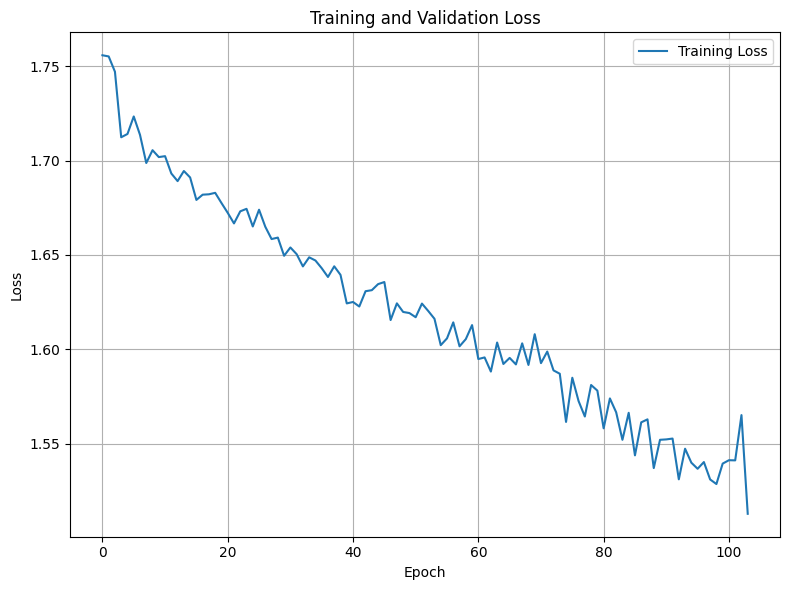

C-index (fold 1): 0.5880 +/- 0.0000

==================== Training Fold 2 ====================

===== Start Training Fold 2 =====
Train samples: 322, Dev samples: 81
Hyperparameters: {'verbose': 0, 'epochs': 1000, 'steps': 1}
Epoch 0: loss = 1.7982, C-index = 0.5848
Epoch 100: loss = 1.5427, C-index = 0.4681
Early stopping at epoch 101 (no improvement for 100 epochs)
[Training Ended]

==================== Fold 2 Training Result ====================
- Best Epoch: 0
- Best C-index: 0.5848


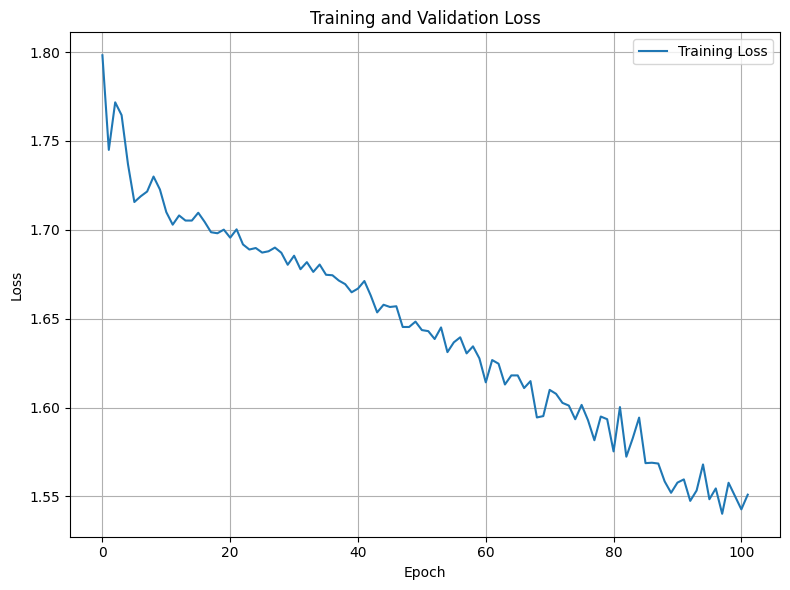

C-index (fold 2): 0.5767 +/- 0.0000

==================== Training Fold 3 ====================

===== Start Training Fold 3 =====
Train samples: 322, Dev samples: 81
Hyperparameters: {'verbose': 0, 'epochs': 1000, 'steps': 1}
Epoch 0: loss = 1.7035, C-index = 0.6693
Epoch 100: loss = 1.5376, C-index = 0.4747
Early stopping at epoch 107 (no improvement for 100 epochs)
[Training Ended]

==================== Fold 3 Training Result ====================
- Best Epoch: 6
- Best C-index: 0.6739


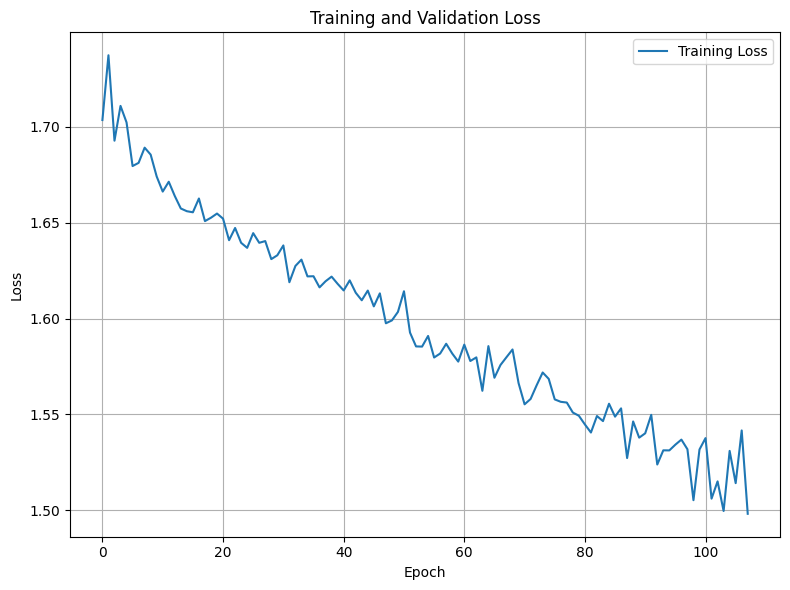

C-index (fold 3): 0.5321 +/- 0.0000

==================== Training Fold 4 ====================

===== Start Training Fold 4 =====
Train samples: 322, Dev samples: 81
Hyperparameters: {'verbose': 0, 'epochs': 1000, 'steps': 1}
Epoch 0: loss = 1.6889, C-index = 0.5461
Epoch 100: loss = 1.4709, C-index = 0.4794
Early stopping at epoch 101 (no improvement for 100 epochs)
[Training Ended]

==================== Fold 4 Training Result ====================
- Best Epoch: 0
- Best C-index: 0.5461


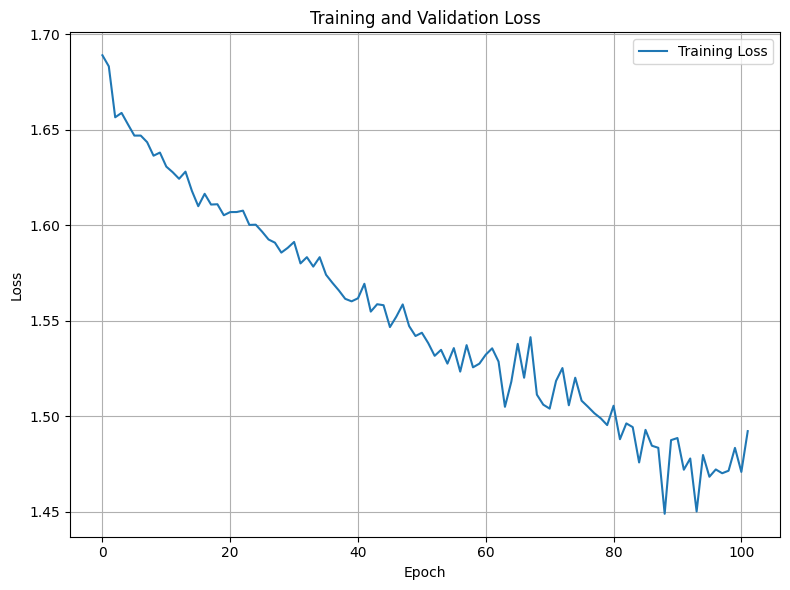

C-index (fold 4): 0.7006 +/- 0.0000

==================== Training Fold 5 ====================

===== Start Training Fold 5 =====
Train samples: 323, Dev samples: 81
Hyperparameters: {'verbose': 0, 'epochs': 1000, 'steps': 1}
Epoch 0: loss = 1.7210, C-index = 0.3970
Epoch 100: loss = 1.4959, C-index = 0.5672
Early stopping at epoch 181 (no improvement for 100 epochs)
[Training Ended]

==================== Fold 5 Training Result ====================
- Best Epoch: 80
- Best C-index: 0.5855


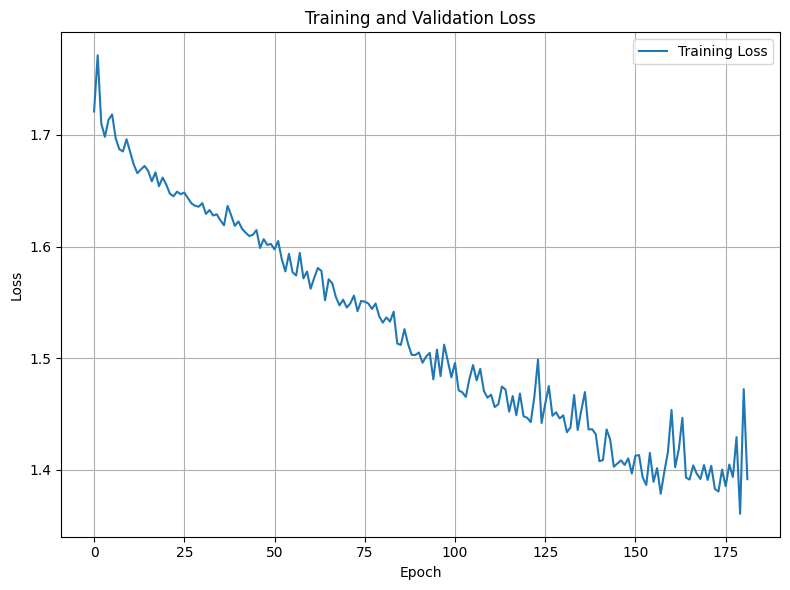

C-index (fold 5): 0.5915 +/- 0.0000

LUAD - Mean C-index: 0.5978 +/- 0.0556


In [462]:
cancer_name = 'LUAD'    # add LUSC

# feature_selection_methods = ['variance', 'kegg', 'reactome', 'cascaded_wx']
feature_selection_methods = ['specific_gene']

for method in feature_selection_methods:
  print(f'\n========== Running with {method} feature selection ==========')

  # Feature selection
  if method == 'variance':
    selected_features = variance_selection(gene_data)
  elif method == 'specific_gene':
    selected_features = specific_gene_selection(gene_data)
  # elif method == 'kegg':
  #   selected_features = kegg_pathway_selection(gene_data)
  # elif method == 'reactome':
  #   selected_features = reactome_pathway_selection(gene_data)
  # elif method == 'cascaded_wx':
  #   selected_features = cascaded_wx_selection(gene_data)

  # Merge with clinical dataset
  selected_gene_data = gene_data[selected_features]
  merged_data = merge_data(selected_gene_data, clinical_data)

  # 모델 파라미터 설정
  conv1 = 64
  dense = 16
  conv1_size = (1, 10)
  input_shape = (10, 10, 1)
  le, wi = 10, 10

  save_path="/content/"

  # 모델 훈련 및 C-index 계산
  score_tst_list = traindcnncoxmodel(merged_data, cancer_name, conv1, conv1_size, dense, input_shape, save_path, le, wi)

  # # C-index 출력
  # flat_scores = [score for fold_scores in score_tst_list for score in fold_scores]
  # print(f"Test C-index for {cancer_name}: {np.mean(flat_scores):.4f} +/- {np.std(flat_scores):.4f}")
  # print(f'\n{cancer_name} - Fold-wise Best C-index Mean: {np.mean(best_cindex_list):.4f} +/- {np.std(best_cindex_list):.4f}')



In [463]:
# # 예시로 LUAD 사용
# cancer_name = 'LUAD'

# # 모델 파라미터 설정
# conv1 = 64
# dense = 16
# conv1_size = (1, 10)
# input_shape = (10, 10, 1)
# le, wi = 10, 10

# save_path="/content/"

# # 모델 훈련 및 C-index 계산
# score_tst_list = traindcnncoxmodel(merged_data, cancer_name, conv1, conv1_size, dense, input_shape, save_path, le, wi)

# # C-index 출력
# print(f"Test C-index for {cancer_name}: {np.mean(score_tst_list):.4f} +/- {np.std(score_tst_list):.4f}")

### Visualization

In [464]:
# plt.plot(checkpoint.epoch_log, checkpoint.cindex_log, label="Dev C-index")
# plt.xlabel("Epoch")
# plt.ylabel("C-index")
# plt.title("C-index over Epochs")
# plt.legend()
# plt.grid(True)
# plt.show()